<a href="https://colab.research.google.com/github/stepankonev/attention_project/blob/master/tensorflow_explain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -e git+https://github.com/marcoancona/DeepExplain.git#egg=deepexplain
!pip install tensorlayer

Obtaining deepexplain from git+https://github.com/marcoancona/DeepExplain.git#egg=deepexplain
  Cloning https://github.com/marcoancona/DeepExplain.git to ./src/deepexplain
    100% |████████████████████████████████| 2.0MB 13.3MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.49 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Running setup.py develop for deepexplain
  Found existing installation: Pillow 4.1.1
    Uninstalling Pillow-4.1.1:
      Successfully uninstalled Pillow-4.1.1


In [0]:
from deepexplain.tensorflow import DeepExplain
import pathlib
import pandas as pd
import numpy as np
import nibabel as nib
import nibabel.processing
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorlayer as tl
import tensorlayer.layers as tll
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
PATH = pathlib.Path('drive/My Drive/Colab Notebooks/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load data to explain

In [4]:
def load_nii_to_array(nii_path, voxel_size = (2, 2, 2)):
    file_ = nib.load(str(nii_path))
    resampled_img = nibabel.processing.resample_to_output(file_, voxel_size)
    return resampled_img.get_data()

DATASET_SIZE_SCHZ = 1
DATASET_SIZE_CONTROL = 1

key = pd.read_csv(PATH / 'LA5study_targets.csv', index_col='participant_id')
key_control = key[key['diagnosis'] == 'CONTROL']
key_schz = key[key['diagnosis'] == 'SCHZ']
control_ids = list(filter(lambda x: (PATH / 'sMRI' / f'{x}_T1w_space-MNI152NLin2009cAsym_preproc.nii.gz').exists(), key_control.index))
schz_ids = list(filter(lambda x: (PATH / 'sMRI' / f'{x}_T1w_space-MNI152NLin2009cAsym_preproc.nii.gz').exists(), key_schz.index))
np.random.seed(43)
control_ids_sampled = np.random.choice(control_ids, size=DATASET_SIZE_CONTROL)
schz_ids_sampled = np.random.choice(schz_ids, size=DATASET_SIZE_SCHZ)

IMAGE_SHAPE = load_nii_to_array(PATH / 'sMRI' / f'{control_ids_sampled[0]}_T1w_space-MNI152NLin2009cAsym_preproc.nii.gz').shape

data_control = np.zeros((DATASET_SIZE_CONTROL, *IMAGE_SHAPE), dtype='<f4')
for i, index in enumerate(tqdm_notebook(control_ids_sampled)):
    nii = load_nii_to_array(PATH / 'sMRI' / f'{index}_T1w_space-MNI152NLin2009cAsym_preproc.nii.gz')
    data_control[i] = nii
    
data_schz = np.zeros((DATASET_SIZE_SCHZ, *IMAGE_SHAPE), dtype='<f4')
for i, index in enumerate(tqdm_notebook(schz_ids_sampled)):
    nii = load_nii_to_array(PATH / 'sMRI' / f'{index}_T1w_space-MNI152NLin2009cAsym_preproc.nii.gz')
    data_schz[i] = nii
    
data = np.expand_dims(np.vstack((data_control, data_schz)), axis=-1)

## Define model

In [0]:
def vox_res_block(x, inplanes, planes, prefix, is_train=True):
    print(x.outputs)
    out = tll.Conv3dLayer(x, shape=[3, 3, 3, inplanes, planes], strides=[1, 1, 1, 1, 1], name=prefix + "conv1")
    print(out.outputs)
    out = tll.BatchNormLayer(out, act=tf.nn.relu, is_train=is_train, name=prefix + "bn1")
    out = tll.Conv3dLayer(out, shape=[3, 3, 3, planes, planes], strides=[1, 1, 1, 1, 1], name=prefix + "conv2")
    print(out.outputs)
    out = tll.BatchNormLayer(out, act=tf.nn.relu, is_train=is_train, name=prefix + "bn2")
    out = tll.ElementwiseLayer([x, out], combine_fn=tf.add, name=prefix + "out")
    return out

def vox_res_net(x, num_classes=2, n_filters=32, stride=2, n_blocks=3, dropout=0, n_fc_units=128, is_train=True, reuse=False):
    with tf.variable_scope("VoxResNet", reuse=reuse):
        inputs = tll.InputLayer(x, name="input")
        out = tll.Conv3dLayer(inputs, shape=[3, 3, 3, 1, n_filters], strides=[1, 2, 2, 2, 1], name="conv1")
        print(out.outputs)
        out = tll.BatchNormLayer(out, act=tf.nn.relu, is_train=is_train, name="bn1")
        out = tll.Conv3dLayer(out, shape=[3, 3, 3, n_filters, n_filters], strides=[1, 2, 2, 2, 1], name="conv2")
        print(out.outputs)
        out = tll.BatchNormLayer(out, act=tf.nn.relu, is_train=is_train, name="bn2")

        out = tll.Conv3dLayer(out, shape=[3, 3, 3, n_filters, n_filters * 2], strides=[1, 2, 2, 2, 1], name="conv3")
        print(out.outputs)
        out = vox_res_block(out, n_filters * 2, n_filters * 2, prefix='vox1/', is_train=is_train)
        print(out.outputs)
        out = vox_res_block(out, n_filters * 2, n_filters * 2, prefix='vox2/', is_train=is_train)
        out = tll.BatchNormLayer(out, act=tf.nn.relu, is_train=is_train, name="bn3")

        if n_blocks >= 2:
            out = tll.Conv3dLayer(out, shape=[3, 3, 3, n_filters * 2, n_filters * 2], strides=[1, 2, 2, 2, 1], name="conv4")
            out = vox_res_block(out, n_filters * 2, n_filters * 2, prefix='vox3/', is_train=is_train)
            out = vox_res_block(out, n_filters * 2, n_filters * 2, prefix='vox4/', is_train=is_train)
            out = tll.BatchNormLayer(out, act=tf.nn.relu, is_train=is_train, name="bn4")
        if n_blocks >= 3:
            out = tll.Conv3dLayer(out, shape=[3, 3, 3, 2 * n_filters, n_filters * 2], strides=[1, 2, 2, 2, 1], name="conv5")
            out = vox_res_block(out, n_filters * 2, n_filters * 2, prefix='vox5/', is_train=is_train)
            out = vox_res_block(out, n_filters * 2, n_filters * 2, prefix='vox6/', is_train=is_train)
            out = tll.BatchNormLayer(out, act=tf.nn.relu, is_train=is_train, name="bn5")

        out = tll.FlattenLayer(out)
        out = tll.DenseLayer(out, n_fc_units, act=tf.nn.relu, name='dense')
        out = tll.DenseLayer(out, num_classes, name='output')
        return out

## Run DeepExplain on model trained in `tensorflow_train.ipynb`

In [15]:
tf.reset_default_graph()
with tf.Session() as sess:
    with DeepExplain(session=sess) as de:
        x = tf.placeholder(tf.float32, shape=[None, *IMAGE_SHAPE, 1], name='x')
        y = tf.placeholder(tf.float32, [None, 2], name='y')
        output_test = vox_res_net(x, is_train=False)
        tl.files.load_and_assign_npz(sess=sess, network=output_test, name=PATH / 'model.npz')
        attributions = de.explain('grad*input', output_test.outputs, x, data)  

[TL] InputLayer  VoxResNet/input: (?, 97, 115, 97, 1)


INFO:tensorlayer:InputLayer  VoxResNet/input: (?, 97, 115, 97, 1)


[TL] Conv3dLayer VoxResNet/conv1: shape: [3, 3, 3, 1, 32] strides: [1, 2, 2, 2, 1] pad: SAME act: No Activation


INFO:tensorlayer:Conv3dLayer VoxResNet/conv1: shape: [3, 3, 3, 1, 32] strides: [1, 2, 2, 2, 1] pad: SAME act: No Activation


Tensor("VoxResNet/conv1/bias_add:0", shape=(?, 49, 58, 49, 32), dtype=float32)
[TL] BatchNormLayer VoxResNet/bn1: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


INFO:tensorlayer:BatchNormLayer VoxResNet/bn1: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


[TL] Conv3dLayer VoxResNet/conv2: shape: [3, 3, 3, 32, 32] strides: [1, 2, 2, 2, 1] pad: SAME act: No Activation


INFO:tensorlayer:Conv3dLayer VoxResNet/conv2: shape: [3, 3, 3, 32, 32] strides: [1, 2, 2, 2, 1] pad: SAME act: No Activation


Tensor("VoxResNet/conv2/bias_add:0", shape=(?, 25, 29, 25, 32), dtype=float32)
[TL] BatchNormLayer VoxResNet/bn2: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


INFO:tensorlayer:BatchNormLayer VoxResNet/bn2: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


[TL] Conv3dLayer VoxResNet/conv3: shape: [3, 3, 3, 32, 64] strides: [1, 2, 2, 2, 1] pad: SAME act: No Activation


INFO:tensorlayer:Conv3dLayer VoxResNet/conv3: shape: [3, 3, 3, 32, 64] strides: [1, 2, 2, 2, 1] pad: SAME act: No Activation


Tensor("VoxResNet/conv3/bias_add:0", shape=(?, 13, 15, 13, 64), dtype=float32)
Tensor("VoxResNet/conv3/bias_add:0", shape=(?, 13, 15, 13, 64), dtype=float32)
[TL] Conv3dLayer VoxResNet/vox1/conv1: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


INFO:tensorlayer:Conv3dLayer VoxResNet/vox1/conv1: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


Tensor("VoxResNet/vox1/conv1/bias_add:0", shape=(?, 13, 15, 13, 64), dtype=float32)
[TL] BatchNormLayer VoxResNet/vox1/bn1: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


INFO:tensorlayer:BatchNormLayer VoxResNet/vox1/bn1: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


[TL] Conv3dLayer VoxResNet/vox1/conv2: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


INFO:tensorlayer:Conv3dLayer VoxResNet/vox1/conv2: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


Tensor("VoxResNet/vox1/conv2/bias_add:0", shape=(?, 13, 15, 13, 64), dtype=float32)
[TL] BatchNormLayer VoxResNet/vox1/bn2: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


INFO:tensorlayer:BatchNormLayer VoxResNet/vox1/bn2: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


[TL] ElementwiseLayer VoxResNet/vox1/out: size: (?, 13, 15, 13, 64) fn: add


INFO:tensorlayer:ElementwiseLayer VoxResNet/vox1/out: size: (?, 13, 15, 13, 64) fn: add


Tensor("VoxResNet/vox1/out:0", shape=(?, 13, 15, 13, 64), dtype=float32)
Tensor("VoxResNet/vox1/out:0", shape=(?, 13, 15, 13, 64), dtype=float32)
[TL] Conv3dLayer VoxResNet/vox2/conv1: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


INFO:tensorlayer:Conv3dLayer VoxResNet/vox2/conv1: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


Tensor("VoxResNet/vox2/conv1/bias_add:0", shape=(?, 13, 15, 13, 64), dtype=float32)
[TL] BatchNormLayer VoxResNet/vox2/bn1: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


INFO:tensorlayer:BatchNormLayer VoxResNet/vox2/bn1: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


[TL] Conv3dLayer VoxResNet/vox2/conv2: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


INFO:tensorlayer:Conv3dLayer VoxResNet/vox2/conv2: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


Tensor("VoxResNet/vox2/conv2/bias_add:0", shape=(?, 13, 15, 13, 64), dtype=float32)
[TL] BatchNormLayer VoxResNet/vox2/bn2: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


INFO:tensorlayer:BatchNormLayer VoxResNet/vox2/bn2: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


[TL] ElementwiseLayer VoxResNet/vox2/out: size: (?, 13, 15, 13, 64) fn: add


INFO:tensorlayer:ElementwiseLayer VoxResNet/vox2/out: size: (?, 13, 15, 13, 64) fn: add


[TL] BatchNormLayer VoxResNet/bn3: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


INFO:tensorlayer:BatchNormLayer VoxResNet/bn3: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


[TL] Conv3dLayer VoxResNet/conv4: shape: [3, 3, 3, 64, 64] strides: [1, 2, 2, 2, 1] pad: SAME act: No Activation


INFO:tensorlayer:Conv3dLayer VoxResNet/conv4: shape: [3, 3, 3, 64, 64] strides: [1, 2, 2, 2, 1] pad: SAME act: No Activation


Tensor("VoxResNet/conv4/bias_add:0", shape=(?, 7, 8, 7, 64), dtype=float32)
[TL] Conv3dLayer VoxResNet/vox3/conv1: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


INFO:tensorlayer:Conv3dLayer VoxResNet/vox3/conv1: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


Tensor("VoxResNet/vox3/conv1/bias_add:0", shape=(?, 7, 8, 7, 64), dtype=float32)
[TL] BatchNormLayer VoxResNet/vox3/bn1: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


INFO:tensorlayer:BatchNormLayer VoxResNet/vox3/bn1: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


[TL] Conv3dLayer VoxResNet/vox3/conv2: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


INFO:tensorlayer:Conv3dLayer VoxResNet/vox3/conv2: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


Tensor("VoxResNet/vox3/conv2/bias_add:0", shape=(?, 7, 8, 7, 64), dtype=float32)
[TL] BatchNormLayer VoxResNet/vox3/bn2: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


INFO:tensorlayer:BatchNormLayer VoxResNet/vox3/bn2: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


[TL] ElementwiseLayer VoxResNet/vox3/out: size: (?, 7, 8, 7, 64) fn: add


INFO:tensorlayer:ElementwiseLayer VoxResNet/vox3/out: size: (?, 7, 8, 7, 64) fn: add


Tensor("VoxResNet/vox3/out:0", shape=(?, 7, 8, 7, 64), dtype=float32)
[TL] Conv3dLayer VoxResNet/vox4/conv1: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


INFO:tensorlayer:Conv3dLayer VoxResNet/vox4/conv1: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


Tensor("VoxResNet/vox4/conv1/bias_add:0", shape=(?, 7, 8, 7, 64), dtype=float32)
[TL] BatchNormLayer VoxResNet/vox4/bn1: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


INFO:tensorlayer:BatchNormLayer VoxResNet/vox4/bn1: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


[TL] Conv3dLayer VoxResNet/vox4/conv2: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


INFO:tensorlayer:Conv3dLayer VoxResNet/vox4/conv2: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


Tensor("VoxResNet/vox4/conv2/bias_add:0", shape=(?, 7, 8, 7, 64), dtype=float32)
[TL] BatchNormLayer VoxResNet/vox4/bn2: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


INFO:tensorlayer:BatchNormLayer VoxResNet/vox4/bn2: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


[TL] ElementwiseLayer VoxResNet/vox4/out: size: (?, 7, 8, 7, 64) fn: add


INFO:tensorlayer:ElementwiseLayer VoxResNet/vox4/out: size: (?, 7, 8, 7, 64) fn: add


[TL] BatchNormLayer VoxResNet/bn4: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


INFO:tensorlayer:BatchNormLayer VoxResNet/bn4: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


[TL] Conv3dLayer VoxResNet/conv5: shape: [3, 3, 3, 64, 64] strides: [1, 2, 2, 2, 1] pad: SAME act: No Activation


INFO:tensorlayer:Conv3dLayer VoxResNet/conv5: shape: [3, 3, 3, 64, 64] strides: [1, 2, 2, 2, 1] pad: SAME act: No Activation


Tensor("VoxResNet/conv5/bias_add:0", shape=(?, 4, 4, 4, 64), dtype=float32)
[TL] Conv3dLayer VoxResNet/vox5/conv1: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


INFO:tensorlayer:Conv3dLayer VoxResNet/vox5/conv1: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


Tensor("VoxResNet/vox5/conv1/bias_add:0", shape=(?, 4, 4, 4, 64), dtype=float32)
[TL] BatchNormLayer VoxResNet/vox5/bn1: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


INFO:tensorlayer:BatchNormLayer VoxResNet/vox5/bn1: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


[TL] Conv3dLayer VoxResNet/vox5/conv2: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


INFO:tensorlayer:Conv3dLayer VoxResNet/vox5/conv2: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


Tensor("VoxResNet/vox5/conv2/bias_add:0", shape=(?, 4, 4, 4, 64), dtype=float32)
[TL] BatchNormLayer VoxResNet/vox5/bn2: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


INFO:tensorlayer:BatchNormLayer VoxResNet/vox5/bn2: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


[TL] ElementwiseLayer VoxResNet/vox5/out: size: (?, 4, 4, 4, 64) fn: add


INFO:tensorlayer:ElementwiseLayer VoxResNet/vox5/out: size: (?, 4, 4, 4, 64) fn: add


Tensor("VoxResNet/vox5/out:0", shape=(?, 4, 4, 4, 64), dtype=float32)
[TL] Conv3dLayer VoxResNet/vox6/conv1: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


INFO:tensorlayer:Conv3dLayer VoxResNet/vox6/conv1: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


Tensor("VoxResNet/vox6/conv1/bias_add:0", shape=(?, 4, 4, 4, 64), dtype=float32)
[TL] BatchNormLayer VoxResNet/vox6/bn1: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


INFO:tensorlayer:BatchNormLayer VoxResNet/vox6/bn1: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


[TL] Conv3dLayer VoxResNet/vox6/conv2: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


INFO:tensorlayer:Conv3dLayer VoxResNet/vox6/conv2: shape: [3, 3, 3, 64, 64] strides: [1, 1, 1, 1, 1] pad: SAME act: No Activation


Tensor("VoxResNet/vox6/conv2/bias_add:0", shape=(?, 4, 4, 4, 64), dtype=float32)
[TL] BatchNormLayer VoxResNet/vox6/bn2: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


INFO:tensorlayer:BatchNormLayer VoxResNet/vox6/bn2: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


[TL] ElementwiseLayer VoxResNet/vox6/out: size: (?, 4, 4, 4, 64) fn: add


INFO:tensorlayer:ElementwiseLayer VoxResNet/vox6/out: size: (?, 4, 4, 4, 64) fn: add


[TL] BatchNormLayer VoxResNet/bn5: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


INFO:tensorlayer:BatchNormLayer VoxResNet/bn5: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False


[TL] FlattenLayer VoxResNet/flatten: 4096


INFO:tensorlayer:FlattenLayer VoxResNet/flatten: 4096


[TL] DenseLayer  VoxResNet/dense: 128 relu


INFO:tensorlayer:DenseLayer  VoxResNet/dense: 128 relu


[TL] DenseLayer  VoxResNet/output: 2 No Activation


INFO:tensorlayer:DenseLayer  VoxResNet/output: 2 No Activation


[TL] [*] Load drive/My Drive/Colab Notebooks/model.npz SUCCESS!


INFO:tensorlayer:[*] Load drive/My Drive/Colab Notebooks/model.npz SUCCESS!


In [9]:
print(f'attributions.shape: {attributions.shape}')

attributions.shape: (2, 97, 115, 97, 1)


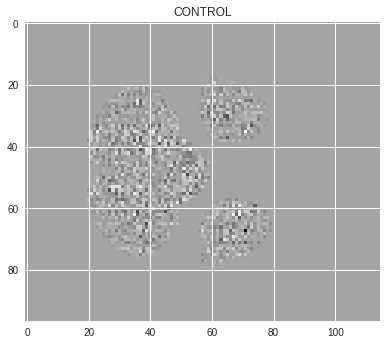

In [23]:
plt.imshow(attributions[0, :, :, 20, 0])
plt.title('CONTROL')
plt.show()

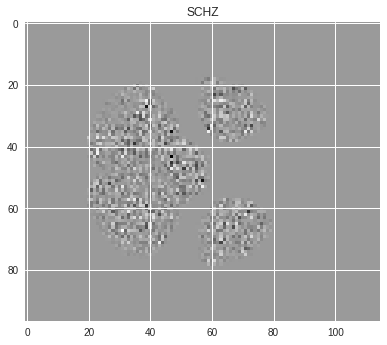

In [24]:
plt.imshow(attributions[1, :, :, 20, 0])
plt.title('SCHZ')
plt.show()